In [6]:
import sys, os
sys.path.insert(1, '../python')
sys.path.insert(1, os.path.join(os.environ['GOOGLE_DRIVE'], 'research/projects/my_dshark/py_dshark'))
sys.path.insert(1, os.path.join(os.environ['GOOGLE_DRIVE'], 'research/projects/electron_drifts/extended_python'))
sys.path.insert(1, os.path.join(os.environ['GOOGLE_DRIVE'], 'research/packages/vlasov_solver'))
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import py_dshark
import pickle
import glob
from extended_util import (kaw_disp_k_space_search,
                           kaw_disp_k_space_interval_search,
                           save_disp_data, 
                           process_stage_1_data, 
                           disp_fix_angle_search,
                           disp_fix_angle_interval_search,
                           kaw_disp_fixed_k_search,
                           kaw_disp_core_drift_search
                          )
from py_vlasov.util import zp, kzkp, list_to_complex, real_imag
from py_vlasov.follow_parameter import follow_k

import time

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5
mpl.rcParams['xtick.major.width'] = 1.1
mpl.rcParams['ytick.major.width'] = 1.1
mpl.rcParams['xtick.minor.width'] = .8
mpl.rcParams['ytick.minor.width'] = .8
mpl.rcParams['legend.fontsize'] = 14
#xtick.major.size     : 3.5      # major tick size in points
#xtick.minor.size     : 2      # minor tick size in points
#xtick.major.width    : 0.8    # major tick width in points
#xtick.minor.width    : 0.6    # minor tick width in points

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# dshark

In [8]:
def fast_freq(kdi, theta):
    return kdi * np.sqrt(1 + kdi**2 * np.cos(np.deg2rad(theta))**2)

def whistler_freq(kdi, theta):
    return 1836 * kdi**2 / (1836 + kdi**2) * np.cos(np.deg2rad(theta))

p_global = {}
p_global['nspecies_in'] = 3
p_global['q_in'] = np.array([1., -1., -1.])
p_global['mu_in'] = np.array([1., 1836., 1836.])
p_global['dens_in'] = np.array([1., .8, .2])
v0c_va = -2.5
p_global['drift_in'] = np.array([0., v0c_va, -p_global['dens_in'][1]/p_global['dens_in'][2]* v0c_va])
t_in = np.array([1, 1, 6])
beta_0 = 1.
anisotropy = np.array([1, 1, 1.2])
p_global['beta_para_in'] = beta_0 * t_in * p_global['dens_in']
p_global['beta_perp_in'] = beta_0 * t_in * p_global['dens_in'] * anisotropy
p_global['kappa_in'] = np.array([50, 50, 50])
p_global['delta_in'] = 1e-3
p_global['increment_r'] = 0
p_global['increment_i'] = 0
p_global['rf_error_in'] = 1e-4
p_global['eps_error_in'] = 1e-6
p_global['omega_r_range'] = [0, 2000]
p_global['omega_i_range'] = [-2000, 2000]
p_global['omega_i_omega_r_range'] = 1.
p_global['parallel_mode_in'] = 0

In [9]:
k_intervals=[1, 5, 20, 45]
nks=[20, 30, 25]
theta = 0
# init_guess = 1.4 - 0.9j
init_guess = fast_freq(k_intervals[0], theta) * (1 + p_global['drift_in'][0]) 
# init_guess = whistler_freq(k_intervals[0], theta) * (1 + p_global['drift_in'][0])
print('guess={0:.3g}'.format(init_guess))
dshark_k, dshark_disp = disp_fix_angle_interval_search(p_global, theta, init_guess, k_intervals=k_intervals, nks=nks)
print('found: {0:.3g}'.format(dshark_disp[0]))

guess=1.41
found: 1.8-0.00135j


# vlasov_solver

In [10]:
def kdi_2_krhoi(kdi, betap):
    return kdi * np.sqrt(betap)

In [11]:
theta = 0
aol = p_global['delta_in']

t_list=t_in
a_list=anisotropy
n_list=p_global['dens_in']
q_list=[1.,-1., -1.]
m_list=[1., 1./1836., 1./1836]
v_list=p_global['drift_in']
n = 10
method = 'numpy'

kdi = 1

target_kde = 1
target_kdi = target_kde * np.sqrt(1836)
target_k = kdi_2_krhoi(target_kdi, beta_0)

k = kdi_2_krhoi(kdi, beta_0)
kz, kp = kzkp(k, theta)

param = [kz, kp, beta_0, t_list, a_list, n_list, q_list,
         m_list, v_list, n, method, aol]

In [12]:
seed_freq = init_guess
freq = follow_k(seed_freq, target_k, param,
                log_incrmt = 0.01, incrmt_method = 'log')

In [13]:
kde_start = kdi / np.sqrt(1836)
kde_end = np.sqrt(freq[1][0]**2 + freq[1][1]**2) /np.sqrt(1836) / np.sqrt(beta_0)
vs_k = np.logspace(np.log10(kde_start), np.log10(kde_end), len(freq[-1]))
vs_disp = np.array(freq[-1])

# Kennel's formula

In [14]:
def kennel_growth_rate(k, omega, nc_n0, beta_cpar, beta_hpar, v0c_vae, a_c, a_h):
    nh_n0 = 1 - nc_n0
    v0h_vae = - v0c_vae * nc_n0 / nh_n0
    vr_wparc = (omega - 1) / k / np.sqrt(beta_cpar)
    vr_wparh = (omega - 1) / k / np.sqrt(beta_hpar)
    v0c_vr = v0c_vae * k / (omega - 1)
    v0h_vr = v0h_vae * k / (omega - 1)
    
    q_c = np.exp(- (vr_wparc * (1 - v0c_vr))**2)
    q_h = np.exp(- (vr_wparh * (1 - v0h_vr))**2)
    B_c = (1 -  v0c_vr) * a_c - 1
    B_h = (1 - v0h_vr) * a_h - 1
    A_numerator = nc_n0 * B_c * q_c / np.sqrt(beta_cpar) + nh_n0 * B_h * q_h / np.sqrt(beta_hpar)
    A_denominator = nc_n0 * q_c / np.sqrt(beta_cpar) + nh_n0 * q_h / np.sqrt(beta_hpar)
    eta = (1 - omega) / np.sqrt(np.pi) / k * (nc_n0 * q_c / np.sqrt(beta_cpar) + nh_n0 * q_h / np.sqrt(beta_hpar))
    if A_denominator == 0:
        A = 0
    else:
        A = A_numerator / A_denominator
    growth_rate = np.pi * (1 - omega)**2 * eta * (A - omega / (1 - omega))
    return growth_rate

In [15]:
v0c_va = v_list[1]
nc_n0 = n_list[1]
beta_cpar = beta_0 * t_list[1]
beta_hpar = beta_0 * t_list[2]
v0c_vae = v0c_va / np.sqrt(1836)
a_c = a_list[1]
a_h = a_list[2]
def helper(k, omega):
    return kennel_growth_rate(k, omega, nc_n0, beta_cpar, beta_hpar, v0c_vae, a_c, a_h)
kennel_k = vs_k
kennel_omega = vs_disp.real / 1836
kennel_gamma = np.array([helper(k, omega) for k, omega in zip(kennel_k, kennel_omega)])

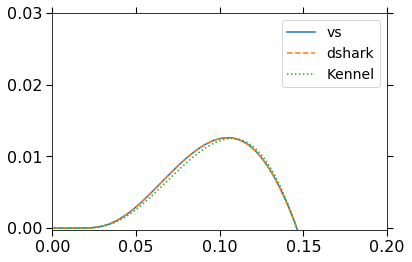

In [16]:
plt.plot(vs_disp.real/1836, vs_disp.imag/1836, label='vs')
plt.plot(dshark_disp.real / 1836, dshark_disp.imag / 1836, '--', label='dshark')
plt.plot(kennel_omega, kennel_gamma/1.2, ':', label='Kennel')
plt.ylim([-3e-4, 3e-2])
plt.xlim([0, 0.2])
plt.legend()

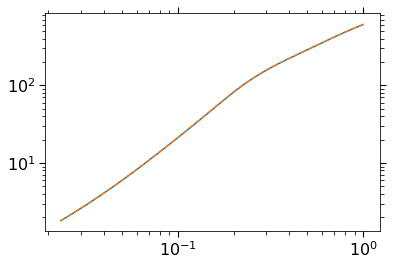

In [12]:
plt.plot(vs_k, vs_disp.real)
plt.plot(dshark_k/43, dshark_disp.real, '--')
plt.yscale('log')
plt.xscale('log')